## Boundary element for potential problems (2D)

### Constant elements

The Laplace equation, also known as the potential equation, is an elliptic partial differential equation written as

\begin{equation}
    \nabla^2 T = 0
\end{equation}
where $\nabla^2 = \partial^2 / \partial x^2 + \partial^2 / \partial y^2 + \partial^2 / \partial z^2 $ is the Laplace operator and $T$ is an unknown system state, for heat conductivity is the temperature, for potential flows, its the velocity potential.

The problem will be solved using the direct boundary element method. The boundary of the problem's domain will be discretized into triangular constant elements with physical nodes located on its centroid. The temperature and its gradient are considered to be constant throughout the element and are only calculated in the physical nodes. The boundary conditions will be applied using the collocation technique. The boundary integral equation which describes the problem is given by

\begin{equation}
\int_{\Gamma} T(x') \frac{\partial T^{\ast}}{\partial n}(x,x') d\Gamma + c (x') T(x') = \int_{\Gamma} \frac{\partial T}{\partial n}(x') T^{\ast}(x,x') d\Gamma,
\end{equation}
where $T$ and $\frac{\partial T}{\partial n}$ are the temperature and its gradient, $n$ is the unit normal vector on the boundary $\Gamma$ of the problem's domain $\Omega$, $( \Gamma = \partial \Omega)$. The superscript in $T^{\ast}$ denotes the fundamental solution of $T$. The fundamental solution corresponds to a source point in an infinite domain when applied to the Laplace equation, where $x'$ is the source point, $x$ is a field point,


\begin{equation}
    \nabla^2 T^{\ast} = \delta(x,x').
\end{equation}

In [1]:
include("../src/const3D_tri/dep.jl")
include("../src/const3D_tri/dad4.jl")

dad4 (generic function with 2 methods)

In [2]:
L = 1 # Length of the cubes side [m]
NOS_GEO, ELEM, CCFace, fc, k = dad4(L) # Data input for a cube of side L
NOS = mostra_geoTRI(NOS_GEO,ELEM) # Generate the physical nodes for constant elements          
nnos = size(NOS,1)  # Number of physical nodes, same as elements when using constant elements
CDC = gera_CDC(ELEM,CCFace); # Builds the boundary conditions matrix
n_pint = 100
PONTOS_int = zeros(n_pint,4)
for i = 1:n_pint
	PONTOS_int[i,:] = [i 0 0 (L/n_pint -0.0001)*i-0.00001]
end
# Gaussian quadrature - generation of points and weights [0,1] for triangular element
npg=12; # Number of integration points                                                         
qsi,w = Gauss_Legendre(0,1,npg) # Generation of the points and weights                        
println("Building G and H matrices...")
@time G,H,phi_inc = cal_GeH_POT(NOS,NOS_GEO,ELEM,k,qsi,w,0) #Compute the G and H matrices     
println("Applying boundary conditions to build A and b for the linear system...")
@time A,b = aplica_cdc(G,H,CDC) #Applies the boundary conditions and returns matrix A and vector b for the linear system                                                                   
println("Solving the linear system...")
@time x = A\b # Solves the linear system                                                      
println("Separating acoustic pressure from flux...")
@time T,q = monta_Teq(CDC,x) # Applies the boundary conditions to return the velocity potential and flux                                                                                 
println("Solving for domain points.")
T_pint=calc_T_pint_POT(PONTOS_int,NOS_GEO,ELEM,T,q,k,qsi,w,fc);
q_pint=calc_q_pint_POT(PONTOS_int,NOS_GEO,ELEM,T,q,k,qsi,w,fc);

Building G and H matrices...
  1.772215 seconds (3.40 M allocations: 137.764 MiB, 2.13% gc time)
Applying boundary conditions to build A and b for the linear system...
  0.476211 seconds (139.91 k allocations: 7.174 MiB)
Solving the linear system...
  1.292182 seconds (526.70 k allocations: 26.552 MiB, 0.84% gc time)
Separating acoustic pressure from flux...
  0.061636 seconds (4.28 k allocations: 217.259 KiB)
Solving for domain points.


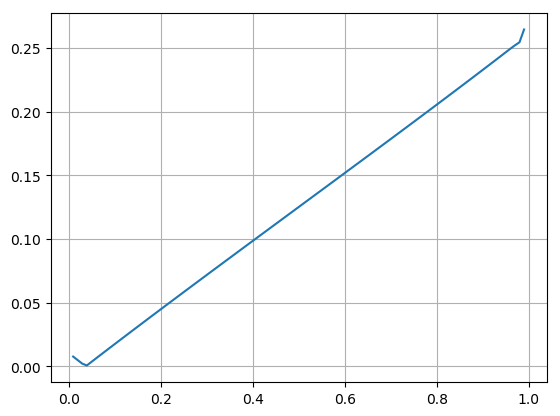

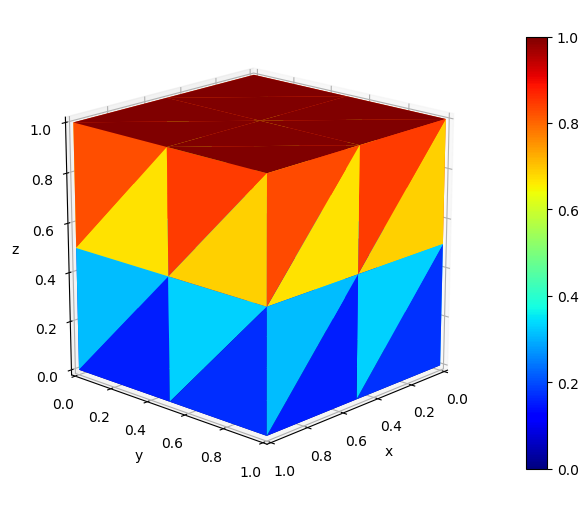

In [3]:
using PyPlot
using PyCall
plt=PyPlot
plt.plot(PONTOS_int[:,4],abs.(T_pint),label="BEM")
grid(1)
@pyimport matplotlib.colors as col
@pyimport matplotlib.cm as cm
@pyimport mpl_toolkits.mplot3d as mp
@pyimport mpl_toolkits.mplot3d.art3d as ar
mostra_resultados2(NOS_GEO,ELEM,abs.(T[:,1]))

### Hierarchical matrices

The boundary elements will now be organized in a tree structure. The distance between elements is used to create a plane of separation. Elements will be separated into two branches, thus the name tree structure. The first branch is called the root and the branches that are no longer divided are called leafs.

In [4]:
include("../src/const3D_tri/H_mat.jl")
include("../src/const3D_tri/ACA.jl")
include("../src/const3D_tri/interp.jl")
using KrylovMethods

In [5]:
## H-Matrix - Interpolation using Lagrange polynomial                                         
println("Building Tree and blocks using H-Matrices.")
@time Tree,block = cluster(NOS[:,2:4],floor(Int,sqrt(length(NOS))),2);

Building Tree and blocks using H-Matrices.


In [10]:
println("Building A and b matrices using H-Matrix with interpolation.")
# Gaussian quadrature - generation of points and weights [0,1] for triangular element
npg=12; # Number of integration points                                                         
qsi_tri,w_tri = Gauss_Legendre(0,1,npg) # Generation of the points and weights                         
qsi,w = Gauss_Legendre(-1,1,npg) # Generation of the points and weights                        
@time Ai,bi = interp(Tree,block,[NOS, NOS_GEO, ELEM, k, CDC,qsi,w,qsi_tri,w_tri])
xi = gmres(vet->matveccheia(Ai,vet,block,Tree),bi,5,tol=1e-5,maxIter=1000,out=0);

Building A and b matrices using H-Matrix with interpolation.
  0.173799 seconds (3.11 M allocations: 122.931 MiB, 17.09% gc time)


In [11]:
println(sum(xi[1] - x));
Ti,qi = monta_Teq(CDC, xi[1])
println(sum(Ti-T));println(sum(qi-q));

5.7353666608583875e-5 + 0.0im
3.123753915773575e-5 + 0.0im
2.6116127450848126e-5 + 0.0im
